In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
import torch
from torch import nn
import gin
import ray
import pickle
import io
gin.enter_interactive_mode()
from causal_util import load_env
from causal_util.helpers import lstdct2dctlst
from sparse_causal_model_learner_rl.loss.losses import fit_loss
from sparse_causal_model_learner_rl.loss.causal_discriminator import siamese_feature_discriminator_l2

from sparse_causal_model_learner_rl.metrics.context_rewrite import context_rewriter
from sparse_causal_model_learner_rl.visual.learner_visual import graph_for_matrices
from sparse_causal_model_learner_rl.config import Config
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL

In [2]:
load_config_files(['../sparse_causal_model_learner_rl/configs/kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1.gin',
                   '../sparse_causal_model_learner_rl/configs/kc_dec.gin',
                   '../keychest/config/5x5_1f1c1k_obs.gin'])

['kc_rec_nonlin_gnn_gumbel_siamese_l2-Copy1', 'kc_dec', '5x5_1f1c1k_obs']

In [6]:
gin.bind_parameter('Config.collect_remotely', True)
gin.bind_parameter('Config.n_collectors', 9)
gin.bind_parameter('Config.env_steps', 5000)
gin.bind_parameter('Config.future_buffer_size', 30)
gin.bind_parameter('Normalizer.type_', 'meanstd')
gin.bind_parameter('ManyNetworkCombinedModel.input_batchnorm', True)

In [7]:
ray.init(ignore_reinit_error=True)

2021-02-05 16:25:02,884	ERROR worker.py:660 -- Calling ray.init() again after it has already been called.


In [8]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [9]:
learner = CausalModelLearnerRL(Config(ray_kwargs={'address': '127.0.0.1:6379'}))

2021-02-05 16:25:04,328	WARNING session.py:20 -- Session not detected. You should not be calling this function outside `tune.run` or while using the class API. 


Selecting name 521e86d4-67c6-11eb-8cea-27b3d2a97921
Make environment KeyChest-v0 None {}


In [ ]:
learner.create_trainables()

In [ ]:
env = learner.env

In [ ]:
losses = []
dplus = []

In [ ]:
opt = torch.optim.Adam(lr=1e-3, params=learner.decoder.parameters())

In [ ]:
for i in tqdm(range(1000)):
    if i % 1 == 0:
        ctx = learner.collect_and_get_context()
    
    opt.zero_grad()
    l_obj = siamese_feature_discriminator_l2(**ctx)
    loss = l_obj['loss']
    loss.backward()
    opt.step()
    losses.append(loss.item())
    dplus.append(l_obj['metrics']['distance_plus'])

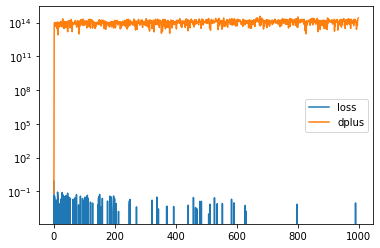

In [12]:
plt.plot(losses, label='loss')
plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [13]:
np.mean(losses[-50:]), np.median(losses[-50:])

(0.015881062222676216, 8.301666821353137e-05)

In [10]:
features = learner.decoder(ctx['obs'])

NameError: name 'ctx' is not defined

In [19]:
f = features.detach().cpu().numpy()

In [20]:
f.shape

(503, 30)

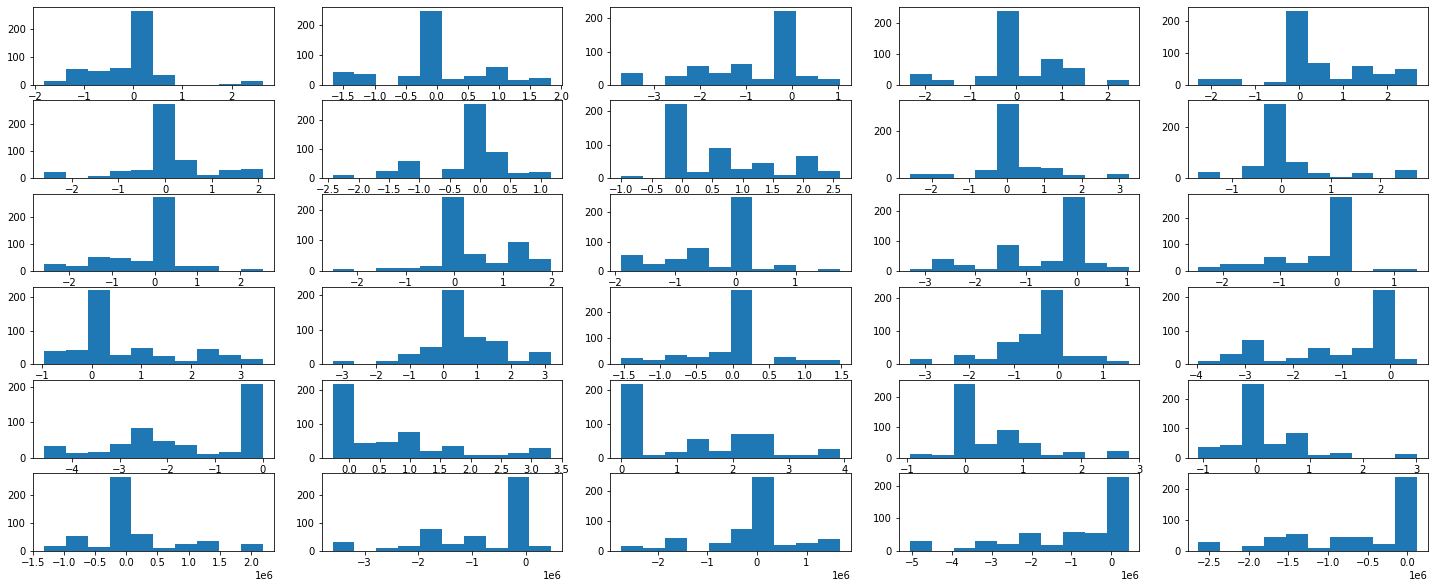

In [21]:
plt.figure(figsize=(25, 10))
for i_f in range(f.shape[1]):
    plt.subplot(6, 5, i_f + 1)
    plt.hist(f[:, i_f])

In [22]:
pd.DataFrame(f).std()

0     7.201790e+05
1     8.053239e+05
2     1.170532e+06
3     9.609772e+05
4     1.066911e+06
5     9.101954e+05
6     6.416958e+05
7     8.275274e+05
8     9.841901e+05
9     8.733838e+05
10    8.803597e+05
11    7.949693e+05
12    7.183433e+05
13    1.003435e+06
14    7.614726e+05
15    1.120053e+06
16    1.124012e+06
17    5.794402e+05
18    8.904403e+05
19    1.258453e+06
20    1.479048e+06
21    9.530923e+05
22    1.253807e+06
23    7.567367e+05
24    7.351928e+05
25    7.140602e+05
26    1.051015e+06
27    9.066261e+05
28    1.428289e+06
29    7.900763e+05
dtype: float32

<AxesSubplot:>

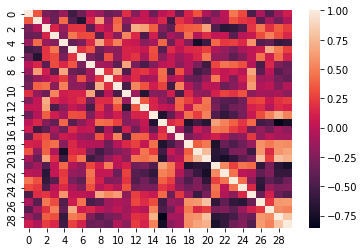

In [23]:
sns.heatmap(pd.DataFrame(f).corr())

In [45]:
env.engine.return_rgb = False

In [46]:
gin.bind_parameter('model_gnn/FCCombinedModel.activation_cls', torch.nn.LeakyReLU)
gin.bind_parameter('model_gnn/FCCombinedModel.hidden_sizes', [100, 100, 100])

In [47]:
learner.non_sparse_model.__init__(feature_shape=learner.feature_shape,
                                  action_shape=learner.action_shape,
                                  additional_feature_shape=learner.additional_feature_shape)
learner.non_sparse_model = learner.non_sparse_model.cuda()

In [48]:
learner.non_sparse_model.model.model.activation

[LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 LeakyReLU(negative_slope=0.01),
 None]

In [49]:
learner.non_sparse_model

ManyNetworkCombinedModel(
  (model): WithInputSwitch(
    (switch): LearnableSwitchSimple()
    (model): FCCombinedModel(
      (fc01): CombinedLinearLayer()
      (fc02): CombinedLinearLayer()
      (fc03): CombinedLinearLayer()
      (fc04): CombinedLinearLayer()
    )
  )
)

In [50]:
learner.non_sparse_model.model.enable_switch

False

In [51]:
mins = None
maxes = None

In [52]:
def normalize(t, mins, maxes):
    return 2 * ((t - mins) / (1e-3 + maxes - mins) - 0.5)

In [64]:
class AdhocWorldModel(nn.Module):
    def __init__(self):
        super(AdhocWorldModel, self).__init__()
        dim = 60
        self.bn = torch.nn.BatchNorm1d(num_features=34)
        self.fc1 = nn.Linear(in_features=34, out_features=dim)
        self.fc2 = nn.Linear(in_features=dim, out_features=dim)
        self.fc3 = nn.Linear(in_features=dim, out_features=dim)
        self.fc4 = nn.Linear(in_features=dim, out_features=32)
        self.activation = nn.Tanh()
        
    def forward(self, f_t, a_t, all):
        x = torch.cat([f_t, a_t], dim=1)
        
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.activation(x)
        
        x = self.fc2(x)
        x = self.activation(x)
        
        x = self.fc3(x)
        x = self.activation(x)
        
        x = self.fc4(x)
        return x

In [65]:
losses = []
metrics = []
losses_emb = []
losses_fit = []

In [66]:
#use_model = learner.non_sparse_model
use_model = AdhocWorldModel().cuda()

In [67]:
gin.bind_parameter('decoder/FCNet.hidden_sizes', [512])
gin.bind_parameter('decoder/FCNet.activation_cls', torch.nn.LeakyReLU)

In [68]:
learner.decoder.__init__(observation_shape=learner.observation_shape,
                         feature_shape=learner.feature_shape)
learner.decoder = learner.decoder.cuda()

In [69]:
opt = torch.optim.Adam(lr=1e-3, params=list(use_model.parameters())+list(learner.decoder.parameters()))

In [70]:
def fit_loss(obs_x, obs_y, action_x, decoder, model, additional_feature_keys,
             model_forward_kwargs=None,
             fill_switch_grad=False,
             opt_label=None,
             divide_by_std=False,
             std_eps=0.05,
             **kwargs):
    """Ensure that the model fits the features data."""

    if model_forward_kwargs is None:
        model_forward_kwargs = {}
    
    f_t1 = decoder(obs_y)#.detach()
        
    have_additional = False
    if additional_feature_keys:
        have_additional = True
        add_features_y = torch.cat([kwargs[k] for k in additional_feature_keys], dim=1)
        
        # WARNING: zeroing output features
#         f_t1 = torch.zeros_like(f_t1)
        f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
    # detaching second part like in q-learning makes the loss jitter

    f_t1_pred = model(decoder(obs_x), action_x, all=have_additional, **model_forward_kwargs)

    loss = (f_t1_pred - f_t1).pow(2)
    loss = loss.sum(1).mean()

    metrics = {'mean_feature': f_t1.mean(0).detach().cpu().numpy(),
               'std_feature': f_t1.std(0).detach().cpu().numpy(),
               'min_feature': f_t1.min().item(),
               'max_feature': f_t1.max().item(),
               #'std_feature_avg': f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0,
               #'inv_std_feature_avg': 1/f_t1_std.detach().cpu().numpy() if f_t1_std is not None else 0.0
              }

    return {'loss': loss,
            'metrics': metrics}

In [71]:
[x.mean() for x in learner.decoder.state_dict().values()]

[tensor(1.3552e-06, device='cuda:0'),
 tensor(-8.3690e-05, device='cuda:0'),
 tensor(-1.9475e-05, device='cuda:0'),
 tensor(0.0019, device='cuda:0')]

In [76]:
ctx_set = False
for i in tqdm(range(10000)):
    if i % 1 == 0 or not ctx_set:
        ctx_set = True
        ctx = learner.collect_and_get_context()
        
#         if mins is None or maxes is None:
#             print("Computing minmax")
#             f_all = learner.decoder(ctx['obs'])
#             mins = f_all.min(dim=0, keepdim=True).values.detach()
#             maxes = f_all.max(dim=0, keepdim=True).values.detach()
        
#         f_t1 = learner.decoder(ctx['obs_y'])#.detach()
#         f_t = learner.decoder(ctx['obs_x'])#.detach()
        
# #         f_t1 = normalize(f_t1, mins, maxes)
# #         f_t = normalize(f_t, mins, maxes)
        
#         add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
#         f_t1 = torch.cat([f_t1, add_features_y], dim=1)
        
#     f_t1_pred = use_model(
#         f_t,
#         ctx['action_x'],
#         all=True)
    
    ctx['non_sparse_model_add'] = use_model
#     ctx['additional_feature_keys'] = []
    l_obj_emb = siamese_feature_discriminator_l2(**ctx)
    l_obj_fit = context_rewriter(function=fit_loss, rewrite={'model': 'non_sparse_model_add'},
                                 divide_by_std=False,
                                 **ctx)
    loss = l_obj_fit['loss'] #+ l_obj_emb['loss']

    
#     loss = nn.MSELoss()(f_t1, f_t1_pred)

    
    opt.zero_grad()
    loss.backward()
    opt.step()
    losses.append(loss.item())
    losses_emb.append(l_obj_emb['loss'].item())
    losses_fit.append(l_obj_fit['loss'].item())
    m = {}
    m.update(l_obj_fit['metrics'])
    m.update(l_obj_emb['metrics'])
    metrics.append(m)

(pid=26587) E0205 16:21:30.303122 26587 26587 plasma_store_provider.cc:113] Failed to put object 526d90b9120af973d25196780100000001000000 in object store because it is full. Object size is 47712506 bytes.
(pid=26587) Waiting 1000ms for space to free up...
(pid=raylet) E0205 16:21:30.302935 26556 26567 store.cc:256] Not enough memory to create the object 526d90b9120af973d25196780100000001000000, data_size=47712506, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


KeyboardInterrupt: 

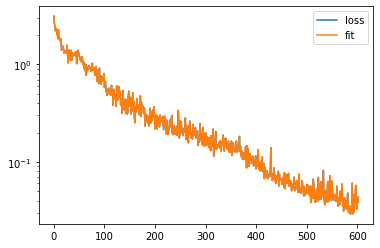

In [77]:
plt.plot(losses, label='loss')
# plt.plot(losses_emb, label='emb')
plt.plot(losses_fit, label='fit')
#plt.plot(dplus, label='dplus')
plt.yscale('log')
plt.legend()

In [78]:
f_t1 = learner.decoder(ctx['obs_y'])#.detach()
f_t = learner.decoder(ctx['obs_x'])#.detach()

#         f_t1 = normalize(f_t1, mins, maxes)
#         f_t = normalize(f_t, mins, maxes)

add_features_y = torch.cat([ctx[k] for k in ctx['additional_feature_keys']], dim=1)
f_t1 = torch.zeros_like(f_t1)
f_t1 = torch.cat([f_t1, add_features_y], dim=1)

f_t1_pred = use_model(
f_t,
ctx['action_x'],
all=True)


<AxesSubplot:>

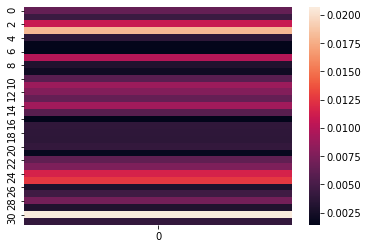

In [79]:
sns.heatmap((f_t1_pred - f_t1).pow(2).mean(0).cpu().detach().numpy().reshape(-1, 1))

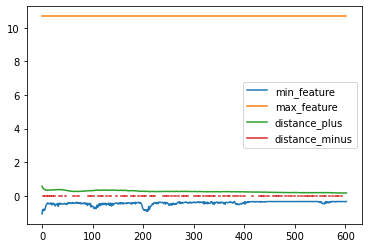

In [80]:
metrics_dct = lstdct2dctlst(metrics)
for key, vals in metrics_dct.items():
    if len(np.array(vals).shape) > 1: continue
    plt.plot(vals, label=key)
plt.legend()
plt.show()

In [81]:
metrics_dct.keys()

dict_keys(['mean_feature', 'std_feature', 'min_feature', 'max_feature', 'distance_plus', 'distance_minus'])

(pid=26583) E0205 16:23:41.700220 26583 26583 plasma_store_provider.cc:113] Failed to put object 7eb81b4da76c52a33db7cfef0100000001000000 in object store because it is full. Object size is 47770427 bytes.
(pid=26583) Waiting 1000ms for space to free up...
(pid=raylet) E0205 16:23:41.699122 26556 26567 store.cc:256] Not enough memory to create the object 7eb81b4da76c52a33db7cfef0100000001000000, data_size=47770427, metadata_size=6, will send a reply of PlasmaError::OutOfMemory


In [82]:
losses[-1]

0.04357163608074188

In [83]:
learner.decoder(ctx['obs_x']).min()

tensor(-0.3339, device='cuda:0', grad_fn=<MinBackward1>)

In [ ]:
# metrics_dct['']